In [1]:
# create a AGn from a gaussian model.
# Calculate the flux from each component and the total flux. (sum image)
# preform TRSF on the sum image. with some noise.
# recover the flux.
# compare the recovered flux to the original flux.

In [2]:
import skimage.measure as measure
from TRSF import trsf
import matplotlib.pyplot as plt
import numpy as np

def get_enclosing_mask(x, y, mask):
    '''
    Returns the mask of the enclosed area of the point (x,y) in the mask.
    '''
    
    # Ensure the point is inside the mask
    if not mask[y, x]:
        return None
    # Create a copy of the mask
    enclosed_mask = np.copy(mask)
    # Perform a flood fill starting from the point
    h, w = mask.shape
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if enclosed_mask[y, x]:
            enclosed_mask[y, x] = False
            if x > 0:
                stack.append((x - 1, y))
            if x < w - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < h - 1:
                stack.append((x, y + 1))
    
    return mask & (~enclosed_mask)

def plottings(cat,ptype,color,img,row=False):
    
    label = False
    for i in range(0,len(cat)):
        row = cat.iloc[i]
        if ptype=='bbox':
            bbox = row.bbox
            if bbox != None:
                xmin = bbox[0] - 1
                xmax = bbox[2] + 1
                ymin = bbox[1] - 1
                ymax = bbox[3] + 1
                if label == False:
                    plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color,label='class 5')
                    label = True
                plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color)
        if ptype == 'point':
            plt.plot(row.y,row.x,'+',color=color)
        
        if ptype == 'polygonwith':
            polygon = row.polygon
            try:
                if label == False:
                    plt.plot(polygon[:,1],polygon[:,0],color=color,label='class 2')
                    label = True
                else:
                    plt.plot(polygon[:,1],polygon[:,0],color=color)  
            except:
                #print('polygonwith Failed')
                continue
                #plottings(cat,'polygonwithout',color,img) 
                
        if ptype == 'polygonwithout':
        # we much create the polygons from the birth and death points
            try:
                birth = row.Birth
                death = row.Death
                mask = np.zeros(img.shape)
                mask = np.logical_or(mask, np.logical_and(img <= birth, img > death))
                #print(row.x_c,row.y_c)
                
                mask = get_enclosing_mask(int(row.x_c),int(row.y_c),mask)
                mask = mask.astype(int)

                contour = measure.find_contours(mask)[0]

                if label == False:
                    plt.plot(contour[:,1],contour[:,0],color=color,label='class 2')
                    label= True
                else:
                    plt.plot(contour[:,1],contour[:,0],color=color)   
            except:
                print(row)


def generate_radio_noise_map(shape, num_gaussians, sigma_x_range, sigma_y_range, amplitude_range):
    """
    Generate a noise map with radio image-like noise using a sum of Gaussians.

    Parameters:
        shape (tuple): Shape of the output array (height, width).
        num_gaussians (int): Number of Gaussians to sum.
        sigma_x_range (tuple): Range of sigma_x values (min, max).
        sigma_y_range (tuple): Range of sigma_y values (min, max).
        amplitude_range (tuple): Range of amplitude values (min, max).

    Returns:
        ndarray: 2D array containing the noise map.
    """
    noise_map = np.zeros(shape)
    
    for _ in range(num_gaussians):
        sigma_x = np.random.uniform(*sigma_x_range)
        sigma_y = np.random.uniform(*sigma_y_range)
        amplitude = np.random.uniform(*amplitude_range)
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        center_x = np.random.randint(0, shape[1])
        center_y = np.random.randint(0, shape[0])
        
        gaussian = amplitude * np.exp(
            -((x - center_x) ** 2) / (2 * sigma_x ** 2) - ((y - center_y) ** 2) / (2 * sigma_y ** 2)
        )
        
        noise_map += gaussian
    
    return noise_map

# Example usage
shape = (200, 200)        # Shape of the output array
num_gaussians = 1000     # Number of Gaussians to sum
sigma_x_range = (2, 2)   # Range of sigma_x values
sigma_y_range = (2, 2)   # Range of sigma_y values
amplitude_range = (0, 1.0)  # Range of amplitude values

noise_map = 0.001*generate_radio_noise_map(shape, num_gaussians, sigma_x_range, sigma_y_range, amplitude_range)
rms = np.sqrt(np.mean(noise_map**2))

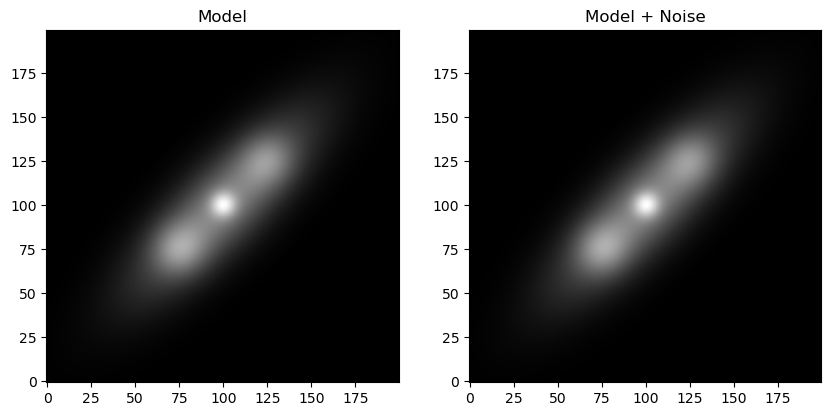

In [3]:
import numpy as np

def generate_2d_gaussian(A,shape, center, sigma_x, sigma_y, angle_deg=0):
    """
    Generate a 2D elliptical Gaussian distribution on a 2D array.

    Parameters:
        shape (tuple): Shape of the output array (height, width).
        center (tuple): Center of the Gaussian distribution (x, y).
        sigma_x (float): Standard deviation along the x-axis.
        sigma_y (float): Standard deviation along the y-axis.
        angle_deg (float): Rotation angle in degrees (default is 0).

    Returns:
        ndarray: 2D array containing the Gaussian distribution.
    """
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    x_c, y_c = center
    angle_rad = np.radians(angle_deg)
    
    # Rotate coordinates
    x_rot = (x - x_c) * np.cos(angle_rad) - (y - y_c) * np.sin(angle_rad)
    y_rot = (x - x_c) * np.sin(angle_rad) + (y - y_c) * np.cos(angle_rad)
    
    # Calculate Gaussian values
    gaussian = A*np.exp(-(x_rot ** 2 / (2 * sigma_x ** 2) + y_rot ** 2 / (2 * sigma_y ** 2)))
    
    return gaussian / (2 * np.pi * sigma_x * sigma_y) # normalize the gaussian


A = 1
x = 75
y = 75
sigma_x = 10
sigma_y = 10
theta = 0
size = 200
gauss1 = generate_2d_gaussian(2.5,(size,size),(x,y),sigma_x,sigma_y,theta)
flux1 = np.sum(gauss1)
gauss2 = generate_2d_gaussian(2,(size,size),(125,125),sigma_x,sigma_y,theta)
flux2 = np.sum(gauss2)
gauss3 = generate_2d_gaussian(A,(size,size),(100,100),5,5,theta)
flux3 = np.sum(gauss3)
gauss4 = generate_2d_gaussian(30,(size,size),(100,100),45,15,-45)
flux4 = np.sum(gauss4)
noise = np.random.normal(0,0.0004,(size,size))
noise_map = 0.00001*generate_radio_noise_map(shape, num_gaussians, sigma_x_range, sigma_y_range, amplitude_range)
model_2 = gauss1+gauss2+gauss3+gauss4+noise_map
# plot the gaussian
# FRII model
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(gauss1+gauss2+gauss3+gauss4,origin='lower',cmap='gray')
ax[0].set_title('Model')
ax[1].imshow(gauss1+gauss2+gauss3+gauss4+noise_map,origin='lower',cmap='gray')
ax[1].set_title('Model + Noise')
plt.show()


   
###########################
 _____   ___    ___    ___ 
|_   _| | _ \  / __|  | __|
  | |   |   /  \__ \  | _| 
  |_|   |_|_\  |___/  |_|  
        
###########################
Topological Radio Source Finder.
        
-------------------
Starting TRSF
NOTICE: Image path: img.fit
Attempting to open Image...
Calculating persistence diagrams and source properties..


Cutouts Completed: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


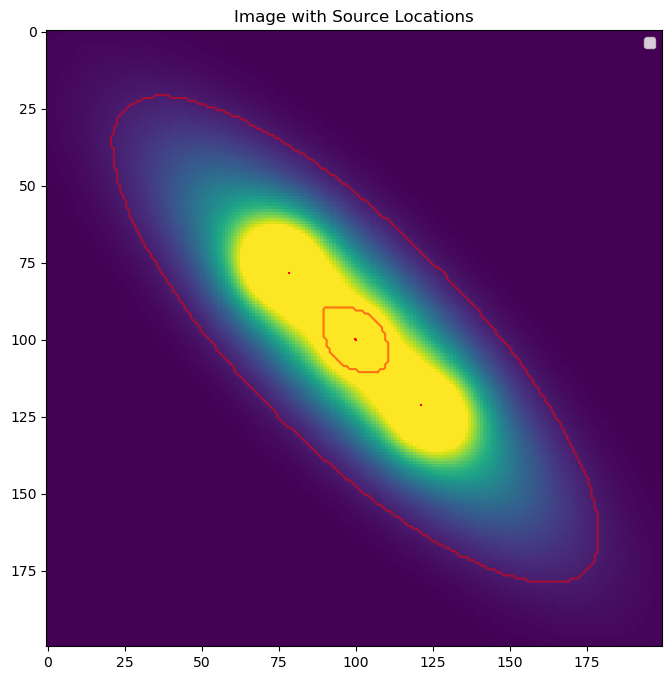

TRSF finished.
Time taken: 0.44460630416870117 seconds
-------------------


In [4]:
trsf_out = trsf('img.fit',gaussian_fitting=True,arrtype=True,arr=gauss1+gauss2+gauss3+gauss4+noise_map,remove_1pixel=True)

6


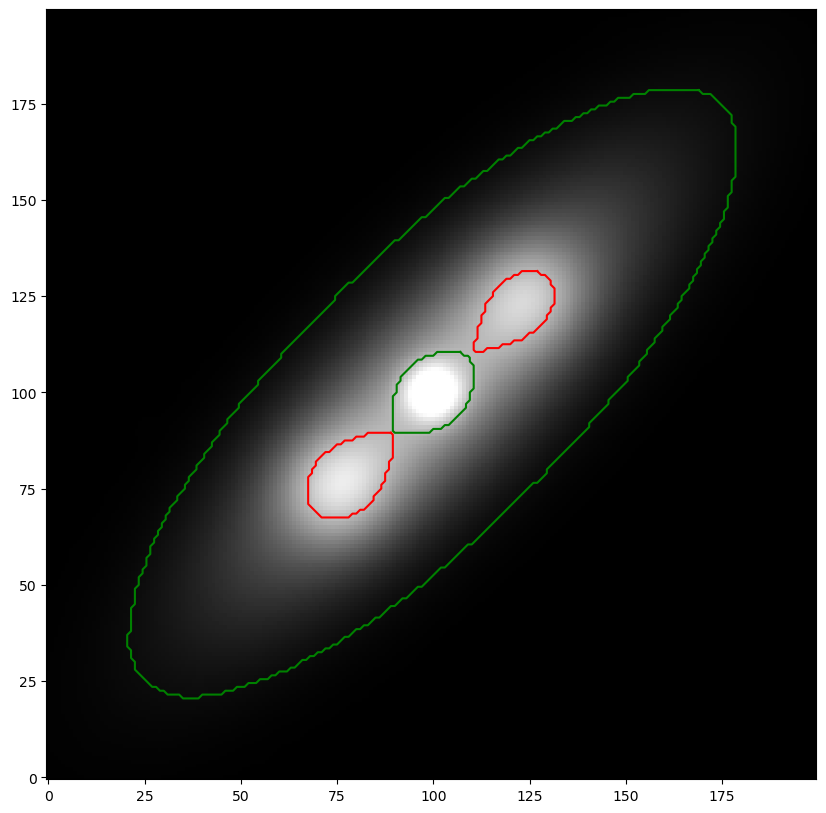

In [5]:
image = trsf_out.full_img
catalogue = trsf_out.catalogue
print(len(catalogue))
catalogue['Class'][np.isnan(catalogue['Class'])] = 2
cat0 = catalogue[catalogue['Class'] == 0]
cat1 = catalogue[catalogue['Class'] == 1]
cat2 = catalogue[catalogue['Class'] == 2]
cat3 = catalogue[catalogue['Class'] == 3]
cat4 = catalogue[catalogue['Class'] == 4]
cat5 = catalogue[catalogue['Class'] == 5]
plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower',cmap='gray',vmax=0.01)
plottings(cat0,'polygonwithout',color='k',img=image)
plottings(cat5,'polygonwithout',color='b',img=image)
plottings(cat1,'polygonwithout',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'polygonwithout',color='y',img=image)
plottings(cat4,'polygonwithout',color='m',img=image)
plt.show()

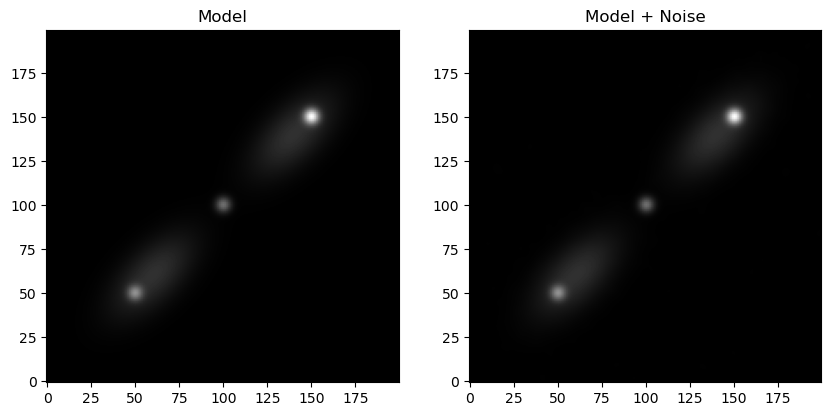

In [6]:
# FRII 2.
gauss1 = generate_2d_gaussian(1, (size, size), (100, 100), 3, 3,0)
gauss2 = generate_2d_gaussian(1, (size, size), (50, 50), 3, 3,0)
gauss3 = generate_2d_gaussian(10, (size, size), (60, 60), 10, 20,45)
gauss4 = generate_2d_gaussian(2, (size, size), (150, 150), 3, 3,0)
gauss5 = generate_2d_gaussian(10, (size, size), (140, 140), 10, 20,45)
noise_map = 0.0001*generate_radio_noise_map(shape, num_gaussians, sigma_x_range, sigma_y_range, amplitude_range)
test_data1 = gauss1+gauss2+gauss3+gauss4+gauss5+noise_map
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(gauss1+gauss2+gauss3+gauss4+gauss5,origin='lower',cmap='gray')
ax[0].set_title('Model')
ax[1].imshow(gauss1+gauss2+gauss3+gauss4+gauss5+noise_map,origin='lower',cmap='gray')
ax[1].set_title('Model + Noise')
plt.show()

   
###########################
 _____   ___    ___    ___ 
|_   _| | _ \  / __|  | __|
  | |   |   /  \__ \  | _| 
  |_|   |_|_\  |___/  |_|  
        
###########################
Topological Radio Source Finder.
        
-------------------
Starting TRSF
NOTICE: Image path: img.fit
Attempting to open Image...
Calculating persistence diagrams and source properties..


Cutouts Completed: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


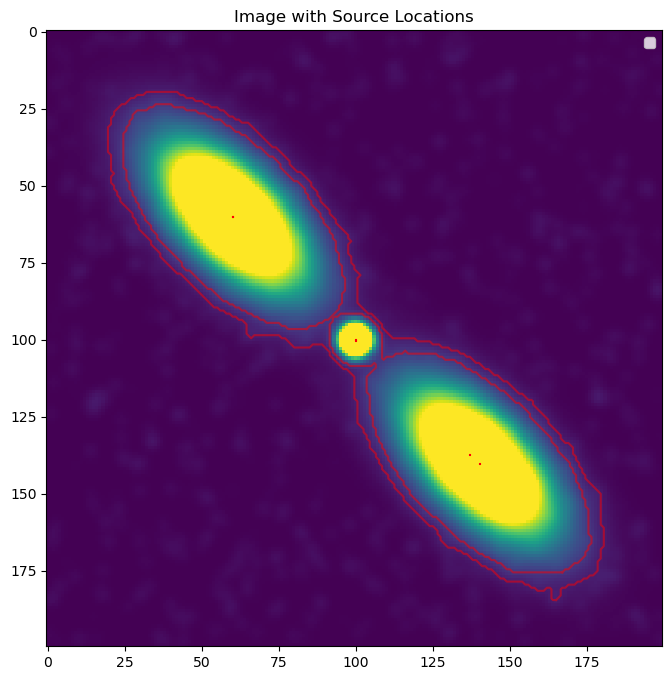

TRSF finished.
Time taken: 2.1630730628967285 seconds
-------------------


In [7]:
trsf_out = trsf('img.fit',gaussian_fitting=True,arrtype=True,arr=gauss1+gauss2+gauss3+gauss4+gauss5+noise_map,remove_1pixel=True)

9


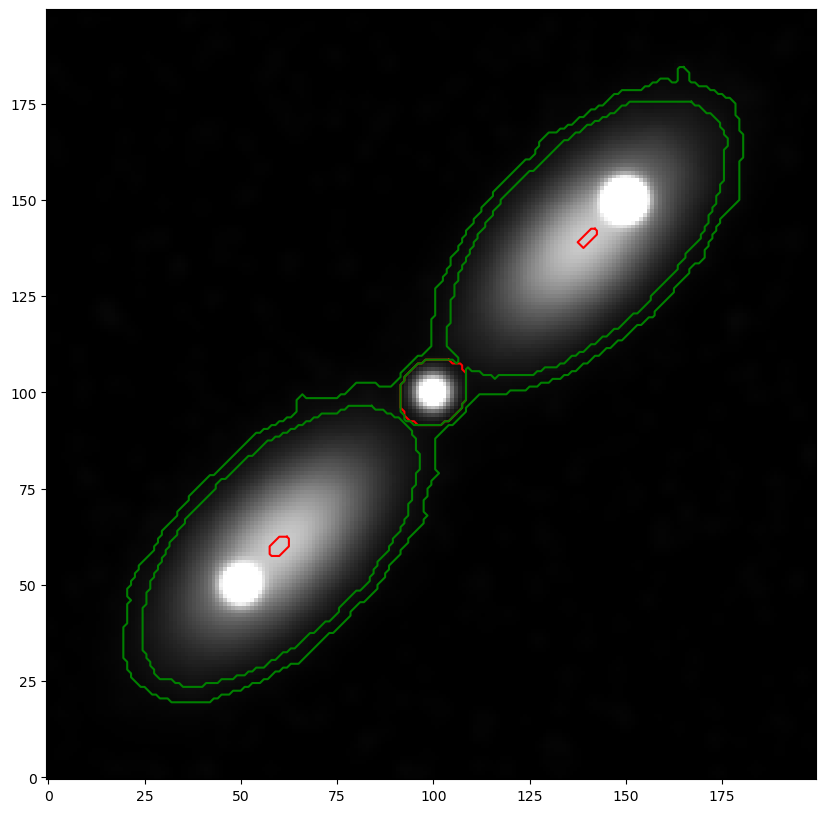

In [8]:
image = trsf_out.full_img
catalogue = trsf_out.catalogue
print(len(catalogue))
catalogue['Class'][np.isnan(catalogue['Class'])] = 2
cat0 = catalogue[catalogue['Class'] == 0]
cat1 = catalogue[catalogue['Class'] == 1]
cat2 = catalogue[catalogue['Class'] == 2]
cat3 = catalogue[catalogue['Class'] == 3]
#cat4 = catalogue[catalogue['Class'] == 4]
#cat5 = catalogue[catalogue['Class'] == 5]
plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower',cmap='gray',vmax=0.01)
plottings(cat0,'polygonwithout',color='k',img=image)
plottings(cat5,'polygonwithout',color='b',img=image)
plottings(cat1,'polygonwithout',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat4,'polygonwithout',color='m',img=image)
plt.show()

1.0
9.0
9.000000000000002
19.918049357892983
19.866859955266683
15.659979046000188
74.44488835915985


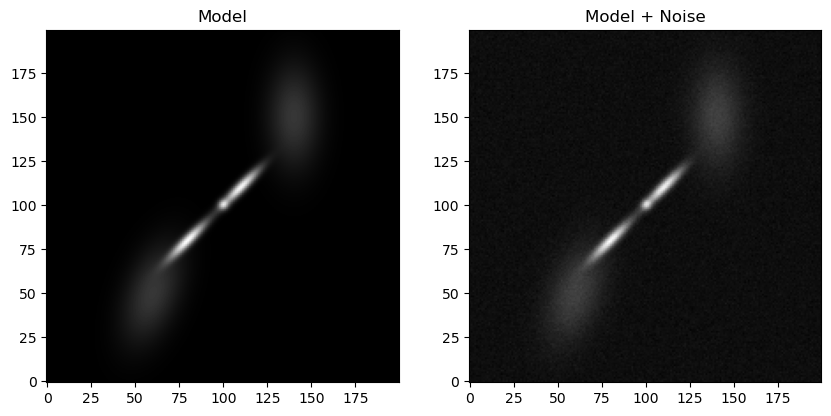

In [17]:
#FRI jets with plumes
gauss1 = generate_2d_gaussian(1,(size,size),(100,100),2,2,0) # bright spot
Gauss1_tot_f = np.sum(gauss1)
print(Gauss1_tot_f)
gauss2 = generate_2d_gaussian(9,(size,size),(110,110),10,2,-45) # jet
Gauss2_tot_f = np.sum(gauss2)
print(Gauss2_tot_f)
gauss3 = generate_2d_gaussian(9,(size,size),(80,80),10,2,-45) # jet
Gauss3_tot_f = np.sum(gauss3)
print(Gauss3_tot_f)
gauss4 = generate_2d_gaussian(20,(size,size),(60,50),10,20,20) # bright spot
Gauss4_tot_f = np.sum(gauss4)
print(Gauss4_tot_f)
gauss5 = generate_2d_gaussian(20,(size,size),(140,150),10,20,0) # bright spot
Gauss5_tot_f = np.sum(gauss5)
print(Gauss5_tot_f)
gauss6 = generate_2d_gaussian(50,(size,size),(1,1),10,10,0) # bright spot
Gauss6_tot_f = np.sum(gauss6)
print(Gauss6_tot_f)
Total_model_f = Gauss1_tot_f + Gauss2_tot_f + Gauss3_tot_f + Gauss4_tot_f + Gauss5_tot_f + Gauss6_tot_f
print(Total_model_f)
noise = np.random.normal(0,0.001,(size,size))

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(gauss1+gauss2+gauss3+gauss4+gauss5,origin='lower',cmap='gray')
ax[0].set_title('Model')
ax[1].imshow(gauss1+gauss2+gauss3+gauss4+gauss5+noise,origin='lower',cmap='gray')
ax[1].set_title('Model + Noise')
plt.show()

0.0004529069652946824


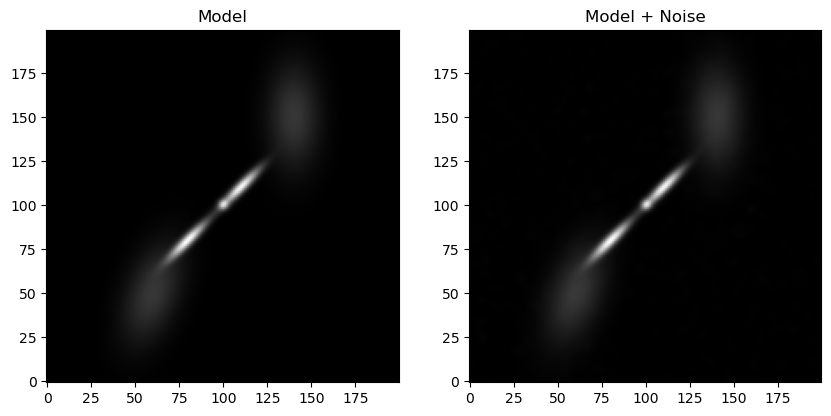

In [10]:
import numpy as np
noise_map = 0.0005*generate_radio_noise_map(shape, num_gaussians, sigma_x_range, sigma_y_range, amplitude_range)
model_1 = gauss1+gauss2+gauss3+gauss4+gauss5+gauss6+noise_map
print(rms)
# Print the generated noise map
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(gauss1+gauss2+gauss3+gauss4+gauss5,origin='lower',cmap='gray')
ax[0].set_title('Model')
ax[1].imshow(gauss1+gauss2+gauss3+gauss4+gauss5+noise_map,origin='lower',cmap='gray')
ax[1].set_title('Model + Noise')
plt.show()

   
###########################
 _____   ___    ___    ___ 
|_   _| | _ \  / __|  | __|
  | |   |   /  \__ \  | _| 
  |_|   |_|_\  |___/  |_|  
        
###########################
Topological Radio Source Finder.
        
-------------------
Starting TRSF
NOTICE: Image path: img.fit
Attempting to open Image...
Calculating persistence diagrams and source properties..


Cutouts Completed: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


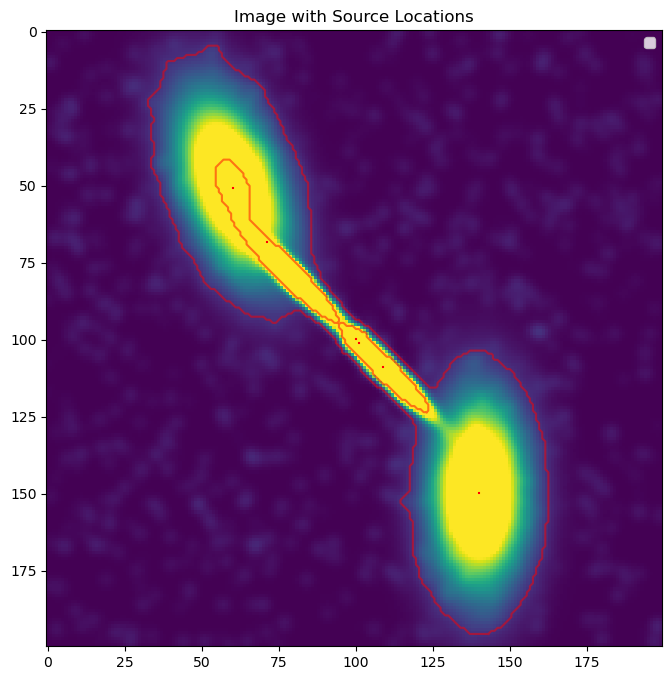

TRSF finished.
Time taken: 0.39296793937683105 seconds
-------------------


In [11]:
from TRSF import trsf

trsf_out = trsf('img.fit',gaussian_fitting=True,arrtype=True,arr=gauss1+gauss2+gauss3+gauss4+gauss5+noise_map,remove_1pixel=True)

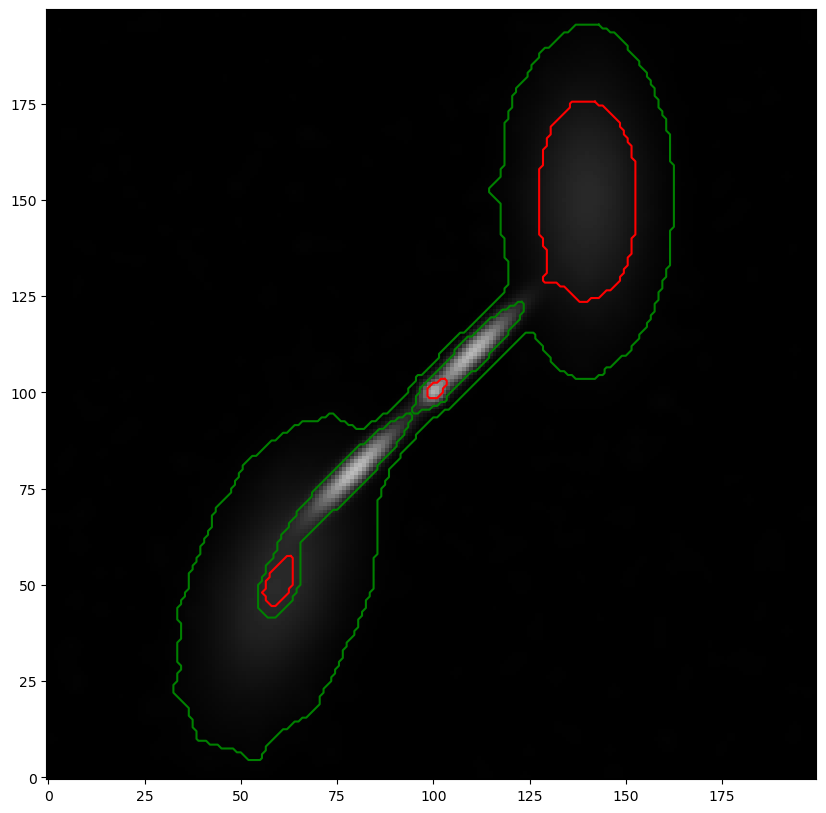

In [12]:
image = trsf_out.full_img
catalogue = trsf_out.catalogue
catalogue['Class'][np.isnan(catalogue['Class'])] = 2
cat0 = catalogue[catalogue['Class'] == 0]
cat1 = catalogue[catalogue['Class'] == 1]
cat2 = catalogue[catalogue['Class'] == 2]
cat3 = catalogue[catalogue['Class'] == 3]
cat4 = catalogue[catalogue['Class'] == 4]
cat5 = catalogue[catalogue['Class'] == 5]
plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower',cmap='gray',vmax=0.1)
plottings(cat0,'polygonwithout',color='k',img=image)
plottings(cat5,'polygonwithout',color='b',img=image)
plottings(cat1,'polygonwithout',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'polygonwithout',color='y',img=image)
plottings(cat4,'polygonwithout',color='m',img=image)
plt.show()

In [16]:
catalogue

,index,amp,x,y,sigma_x,sigma_y,theta,peak_flux,bbox,Class,...,flux_peak_corr,flux_tot_corr,area,x2,y2,single,polygon,y_c,x_c,Int_flux
0,0.0,0.048642,93.474320,93.412873,2.400794,40.908347,-8065.248344,0.074044,"[5, 33, 196, 163]",2.0,...,0.074044,57.184565,7106,NaN,NaN,NaN,None,99.834225,99.968337,23.363669
1,1.0,0.073848,108.399617,108.384677,1.792604,12.115381,2832.930383,0.071655,"[95, 95, 124, 124]",2.0,...,0.071655,8.541288,230,NaN,NaN,NaN,None,108.817391,108.860870,10.076847
2,2.0,0.075469,100.355162,100.349277,1.119935,3.251817,-424.899792,0.067812,"[99, 99, 104, 104]",1.0,...,0.067812,0.946178,17,NaN,NaN,NaN,None,100.882353,100.882353,1.726910
3,3.0,0.020845,60.494186,51.121973,2.122563,6.035144,-0.485470,0.016703,"[45, 56, 58, 64]",1.0,...,0.016703,1.025589,64,NaN,NaN,NaN,None,50.750000,60.062500,1.677782
4,4.0,0.017570,140.025820,149.838560,8.475996,16.563586,-0.013246,0.015957,"[124, 128, 176, 153]",1.0,...,0.015957,11.580450,1061,NaN,NaN,NaN,None,149.636192,139.966070,15.458998
5,5.0,0.073002,78.858528,78.845681,1.929515,11.806324,-7.060494,0.074044,"[42, 55, 95, 95]",2.0,...,0.074044,11.785844,444,NaN,NaN,NaN,None,68.105856,71.274775,10.448806
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.074044,57.184565,7106,0.0,0.0,2.0,"[[195.5, 143.0], [195.5, 142.0], [195.5, 141.0...",NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.071655,8.541288,230,95.0,94.0,2.0,"[[123.5, 123.0], [123.5, 122.0], [123.0, 121.5...",NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.074044,11.785844,444,0.0,0.0,2.0,"[[94.5, 94.0], [94.5, 93.0], [94.0, 92.5], [93...",NaN,NaN,NaN


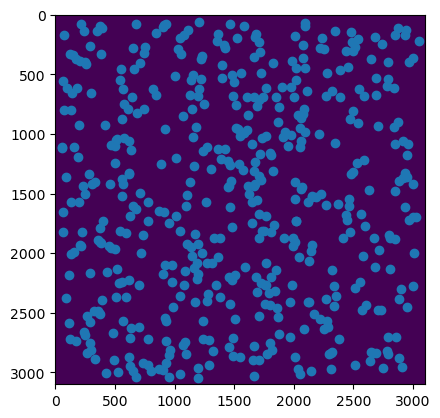

In [43]:
# create a simulated field. 
# image size 3000x3000

# sample 500 points from a uniform distribution
# randomly sample min and maj axis from a gamma distribution centered at 5
# randomly sample angle from a uniform distribution
# randomly sample amplitude from a uniform distribution
# x and y center will be the same as the coordinates of the point
import pandas as pd
x = np.random.uniform(50,3050,500) # prevent edge sources
y = np.random.uniform(50,3050,500) # prevent edge sources

df = pd.DataFrame({'x':x, 'y':y})
# create a empty image 3000x3000
img = np.zeros((3100,3100))
plt.scatter(x,y)
plt.imshow(img)
plt.show()


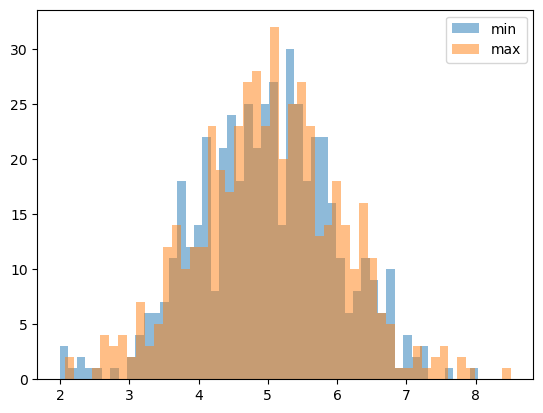

In [44]:
min = np.random.normal(5,1,500)
min = np.maximum(min,2)
max = np.random.normal(5,1,500)
max = np.maximum(max,1)

df['min'] = min
df['maj'] = max
plt.hist(min, bins=50, alpha=0.5, label='min')
plt.hist(max, bins=50, alpha=0.5, label='max')
plt.legend(loc='upper right')
plt.show()

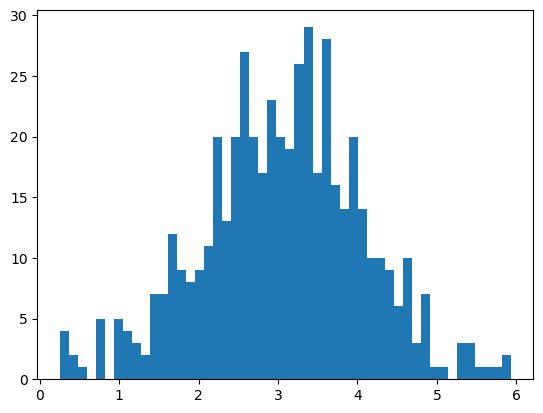

In [45]:
amp = np.random.normal(3,1,500)
amp = np.maximum(amp,0)
df['amp'] = amp

plt.hist(amp,bins=50)
plt.show()


In [46]:
# rotation anlge uniform random between 0 and 2pi
angle = np.random.uniform(0,2*np.pi,500)
df['angle'] = angle

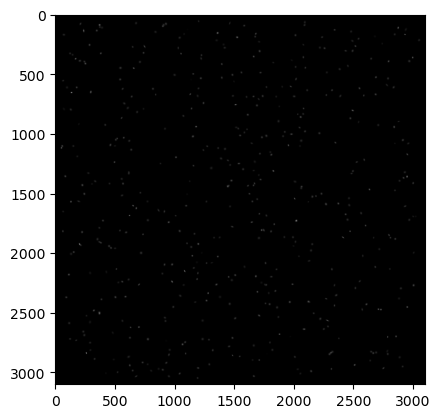

In [48]:

for i in range(0,len(df)):
    row = df.iloc[i]
    gaussian = generate_2d_gaussian(A=row['amp'],shape=img.shape,center=(row['x'],row['y']),sigma_x = row['maj'],sigma_y = row['min'],angle_deg= np.rad2deg(row['angle']))
    img += gaussian



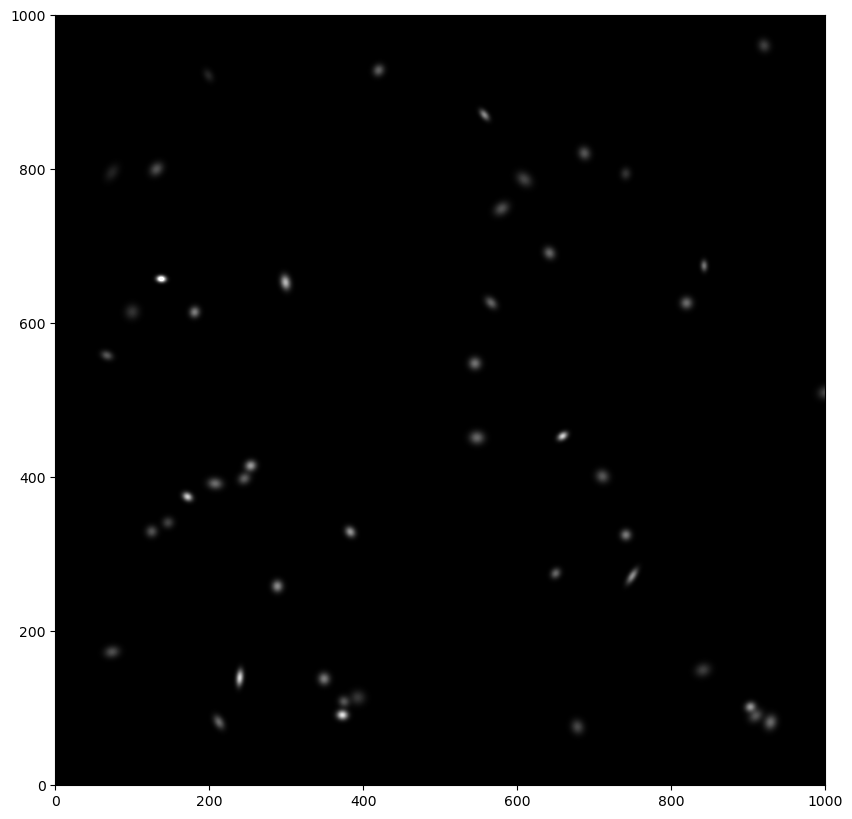

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray',vmax=0.1)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()